# Transformer-based model for `Churn Prediction` on the Telco dataset

Since Transformers are originally built for sequential data (like text or time series), applying them to tabular data requires adapting the input into a format suitable for attention mechanisms.

#### 🔍 TabTransformer Architecture for Telco Churn Prediction

The **TabTransformer** adapts Transformer-based deep learning models for **tabular data**, particularly effective when handling **categorical features**. It combines both categorical and numerical data to make predictions (e.g., customer churn).

---

##### 🧱 Architecture 

```
Input:
    ├── Categorical Features (e.g., Contract, PaymentMethod, etc.)
    └── Numerical Features (e.g., tenure, MonthlyCharges)

Step 1: Embedding Layer
    └── Each categorical feature is passed through its own embedding layer.
        - Categorical inputs (integers) → dense vectors (embeddings)
        - Output shape: [batch_size, num_categorical_features, embedding_dim]

Step 2: Transformer Encoder
    └── Stack of Transformer layers that model relationships across categorical features.
        - Multi-head Self-Attention: captures feature interactions.
        - LayerNorm and Residual Connections for stability.
        - Feedforward MLP layers refine representations.

Step 3: Flatten Transformer Output
    └── The output tensor from the encoder is flattened into a single vector.
        - Shape: [batch_size, num_categorical_features * embedding_dim]

Step 4: Concatenate with Numerical Features
    └── Combine the flattened transformer output with raw numerical features.
        - Shape after concat: [batch_size, total_feature_dim]

Step 5: Fully Connected Layers
    └── A simple feedforward neural network processes the combined features.
        - Linear → ReLU → Dropout (optional) → Linear

Step 6: Output Layer
    └── A single neuron with Sigmoid activation to output churn probability.
        - Output: [batch_size, 1], values in range [0, 1]

Loss:
    └── Binary Cross Entropy (BCELoss)

Optimizer:
    └── Adam (learning rate usually set to 0.001)

Final Prediction:
    └── If sigmoid output > 0.5 → Predict churn (1)
        └── else → No churn (0)
```

---

## Summary

TabTransformer smartly replaces traditional one-hot encoded categorical features with contextual embeddings using attention mechanisms, improving generalization in tabular datasets with complex categorical interactions. It’s powerful for tasks like churn prediction where understanding inter-feature relations matters.


### Libraries Required

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader


### Load & Preprocess Dataset

In [2]:
df = pd.read_csv("../data/raw/rawdata.csv")



In [3]:
# Convert TotalCharges to numeric
df["TotalCharges"] = pd.to_numeric(df["TotalCharges"], errors='coerce')

In [4]:
df.isnull().sum()

customerID           0
gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
Churn                0
dtype: int64

In [5]:
df['TotalCharges'].fillna((df['TotalCharges'].mean()), inplace=True)
df.isnull().sum()   

C:\Users\user\AppData\Local\Temp\ipykernel_1184\2819633103.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['TotalCharges'].fillna((df['TotalCharges'].mean()), inplace=True)


customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

In [6]:
# Drop customerID
df.drop("customerID", axis=1, inplace=True)

In [7]:
df.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [8]:
df['Churn'].value_counts()

Churn
No     5174
Yes    1869
Name: count, dtype: int64

In [9]:
# Encode target variable
df["Churn"] = df["Churn"].map({"Yes": 1, "No": 0})
df['Churn'].value_counts()

Churn
0    5174
1    1869
Name: count, dtype: int64

In [10]:
df.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,0
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,0
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,1
3,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,0
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,1


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            7043 non-null   object 
 1   SeniorCitizen     7043 non-null   int64  
 2   Partner           7043 non-null   object 
 3   Dependents        7043 non-null   object 
 4   tenure            7043 non-null   int64  
 5   PhoneService      7043 non-null   object 
 6   MultipleLines     7043 non-null   object 
 7   InternetService   7043 non-null   object 
 8   OnlineSecurity    7043 non-null   object 
 9   OnlineBackup      7043 non-null   object 
 10  DeviceProtection  7043 non-null   object 
 11  TechSupport       7043 non-null   object 
 12  StreamingTV       7043 non-null   object 
 13  StreamingMovies   7043 non-null   object 
 14  Contract          7043 non-null   object 
 15  PaperlessBilling  7043 non-null   object 
 16  PaymentMethod     7043 non-null   object 


In [12]:
df.replace(['No internet service','No phone service'], 'No', inplace=True)

In [13]:
num_cols = ['tenure', 'MonthlyCharges', 'TotalCharges']
cat_cols = ['gender','Partner','Dependents','PhoneService','MultipleLines','InternetService','PaymentMethod',
              'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 
              'Contract', 'PaperlessBilling']

In [14]:
# Normalize numeric columns
scaler = StandardScaler()
df[num_cols] = scaler.fit_transform(df[num_cols])

In [15]:
# Label encode categorical features
encoders = {col: LabelEncoder().fit(df[col]) for col in cat_cols}
for col, encoder in encoders.items():
    df[col] = encoder.transform(df[col])

In [16]:
# Split data
X = df.drop("Churn", axis=1)
y = df["Churn"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [17]:
X_train

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
2142,0,0,0,1,-0.463037,1,0,0,1,0,1,0,0,1,1,0,3,0.002935,-0.417911
1623,0,0,0,0,0.880735,1,1,1,0,1,0,0,1,1,2,1,0,1.078118,1.256667
6074,1,0,1,0,-1.277445,0,0,0,0,0,0,0,0,0,0,1,2,-1.373033,-0.997797
1362,1,0,0,0,-1.155283,1,0,1,0,0,0,0,0,0,0,1,2,0.180747,-0.903088
6754,1,0,0,1,-1.318165,1,1,0,1,1,0,1,0,0,2,1,0,-0.095111,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3772,1,0,1,0,-1.277445,1,0,1,1,0,0,0,1,1,0,1,2,1.004999,-0.966206
5191,0,0,1,1,-0.381597,1,1,0,1,1,1,1,1,1,2,1,1,0.875378,-0.037530
5226,1,0,1,1,-0.829521,1,0,2,0,0,0,0,0,0,0,1,2,-1.449476,-0.873020
5390,1,1,0,0,-0.829521,1,1,1,0,0,1,0,1,1,0,1,2,1.152899,-0.478246


### Dataset & DataLoader

In [18]:
class TabularDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X.values, dtype=torch.float32)
        self.y = torch.tensor(y.values, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]


In [19]:
train_ds = TabularDataset(X_train, y_train)
test_ds = TabularDataset(X_test, y_test)

train_dl = DataLoader(train_ds, batch_size=64, shuffle=True)
test_dl = DataLoader(test_ds, batch_size=64)

### TabTransformer Model

In [ ]:
class TabTransformer(nn.Module):
    def __init__(self, input_dim, n_heads=4, dropout=0.1):
        super().__init__()
        self.embedding = nn.Linear(input_dim, 64)
        encoder_layer = nn.TransformerEncoderLayer(d_model=64, nhead=n_heads, dropout=dropout)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=2)
        self.fc = nn.Sequential(
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(32, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.embedding(x).unsqueeze(1) 
        x = self.transformer(x)
        return self.fc(x.squeeze(1))


### Train the Model

d:\miniconda3\envs\myenv\lib\site-packages\torch\nn\modules\transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch 1, Loss: 0.4773
Epoch 2, Loss: 0.4487
Epoch 3, Loss: 0.4333
Epoch 4, Loss: 0.4267
Epoch 5, Loss: 0.4327
Epoch 6, Loss: 0.4294
Epoch 7, Loss: 0.4279
Epoch 8, Loss: 0.4316
Epoch 9, Loss: 0.4243
Epoch 10, Loss: 0.4192
Epoch 11, Loss: 0.4179
Epoch 12, Loss: 0.4317
Epoch 13, Loss: 0.4291
Epoch 14, Loss: 0.4191
Epoch 15, Loss: 0.4110
Epoch 16, Loss: 0.4023
Epoch 17, Loss: 0.4036
Epoch 18, Loss: 0.4072
Epoch 19, Loss: 0.4083
Epoch 20, Loss: 0.4033
Epoch 21, Loss: 0.3970
Epoch 22, Loss: 0.3986
Epoch 23, Loss: 0.4004
Epoch 24, Loss: 0.3994
Epoch 25, Loss: 0.4067
Epoch 26, Loss: 0.4004
Epoch 27, Loss: 0.3913
Epoch 28, Loss: 0.3858
Epoch 29, Loss: 0.3857
Epoch 30, Loss: 0.3919
Epoch 31, Loss: 0.3765
Epoch 32, Loss: 0.3713
Epoch 33, Loss: 0.3637
Epoch 34, Loss: 0.3772
Epoch 35, Loss: 0.3657
Epoch 36, Loss: 0.3564
Epoch 37, Loss: 0.3499
Epoch 38, Loss: 0.3520
Epoch 39, Loss: 0.3442
Epoch 40, Loss: 0.3493
Epoch 41, Loss: 0.3390
Epoch 42, Loss: 0.3705
Epoch 43, Loss: 0.3719
Epoch 44, Loss: 0.33

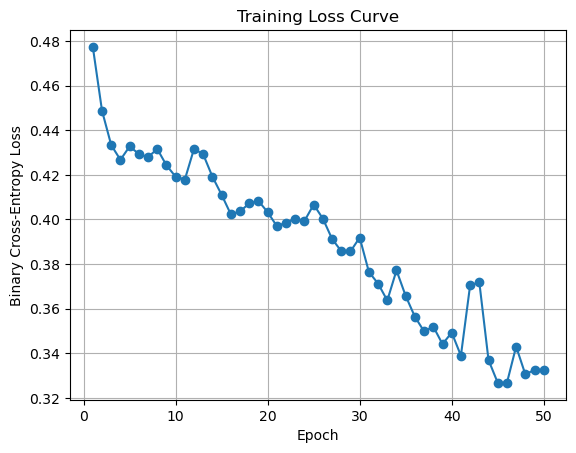

In [21]:
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = TabTransformer(input_dim=X.shape[1]).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.BCELoss()

train_losses = []

# Training loop
for epoch in range(50):
    model.train()
    total_loss = 0
    for xb, yb in train_dl:
        xb, yb = xb.to(device), yb.to(device)
        preds = model(xb).squeeze()
        loss = criterion(preds, yb)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_loss = total_loss / len(train_dl)
    train_losses.append(avg_loss)
    print(f"Epoch {epoch+1}, Loss: {avg_loss:.4f}")

# Plot loss curve
plt.plot(range(1, len(train_losses)+1), train_losses, marker='o')
plt.xlabel('Epoch')
plt.ylabel('Binary Cross-Entropy Loss')
plt.title('Training Loss Curve')
plt.grid(True)
plt.show()


              precision    recall  f1-score   support

           0       0.83      0.91      0.87      1036
           1       0.66      0.50      0.57       373

    accuracy                           0.80      1409
   macro avg       0.75      0.70      0.72      1409
weighted avg       0.79      0.80      0.79      1409

ROC AUC Score: 0.8156


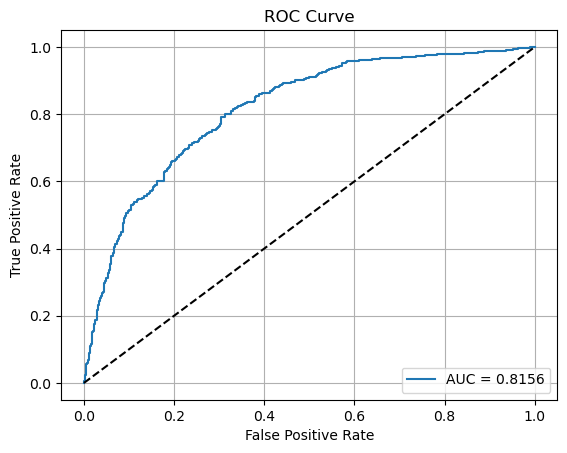

In [23]:
from sklearn.metrics import classification_report, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# Evaluate the model
model.eval()
all_preds, all_targets, all_probs = [], [], []

with torch.no_grad():
    for xb, yb in test_dl:
        xb, yb = xb.to(device), yb.to(device)
        preds = model(xb).view(-1)
        
        # Save predicted probabilities and targets
        all_probs.extend(preds.cpu().numpy())
        all_preds.extend((preds > 0.5).int().cpu().numpy())
        all_targets.extend(yb.view(-1).int().cpu().numpy())

# Convert to NumPy arrays
all_preds = np.array(all_preds)
all_targets = np.array(all_targets)
all_probs = np.array(all_probs)

# Classification report
print(classification_report(all_targets, all_preds))

# ROC AUC Score
roc_auc = roc_auc_score(all_targets, all_probs)
print(f"ROC AUC Score: {roc_auc:.4f}")

# Plot ROC Curve
fpr, tpr, _ = roc_curve(all_targets, all_probs)
plt.figure()
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.4f}')
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


In [24]:
# Save model state_dict
torch.save(model.state_dict(), "../models/transformer_model.pth")

